# imports

In [41]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import experiment as exp
import model as m
import plot
import predict
import runner2 as r

import numpy as np
import matplotlib.pyplot as plt

import os
import torch

import umap
import matplotlib
from sklearn.preprocessing import StandardScaler

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

_ = plt.rcParams['axes.grid'] = False # turn off grid

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
e = exp.load('iter_exps10_3iters', experiment_location='experiments', datadir='Mdata')
np.mean(e.trials[0].LLs)

0.10140363

In [43]:
dataset = e.trials[0].dataset
expt_boundaries = np.concatenate([[0], np.cumsum(dataset.num_units)])
expt_boundaries

lazy loading dataset
Loading expt04
  Time embedding...
  Done.
Loading expt06
  Time embedding...
  Done.
Loading expt09
  Time embedding...
  Done.
Loading expt11
  Time embedding...
  Done.


array([  0,  35,  63,  86, 111])

# pixel activations

In [44]:
dataset[0]['stim'].shape

torch.Size([504])

In [126]:
# take the first row of stimuli, shift it to the left, and up
def lag_stimulus(stimulus):
    stimulus_copy = torch.zeros_like(stimulus).reshape(36,14)
    # copy the first row to the previous row
    stimulus_copy[:,1:] = stimulus.reshape(36,14)[:,:-1]
    return stimulus_copy.reshape(-1)

In [130]:
# create sample stimuli (not lagged)
stimuli_pos = torch.zeros((14*36, 504)).float()
stimuli_neg = torch.zeros((14*36, 504)).float()
# put a +1 pixel at every spatial position every 20 frames
pos = 0
for i in range(stimuli_pos.shape[0]):
    if i > 0 and i % 14 == 0:
        pos += 14
    if i > 0:
        stimuli_pos[i,:] = lag_stimulus(stimuli_pos[i-1,:])
        stimuli_neg[i,:] = lag_stimulus(stimuli_neg[i-1,:])
    stimuli_pos[i, pos] = 1
    stimuli_neg[i, pos] = -1

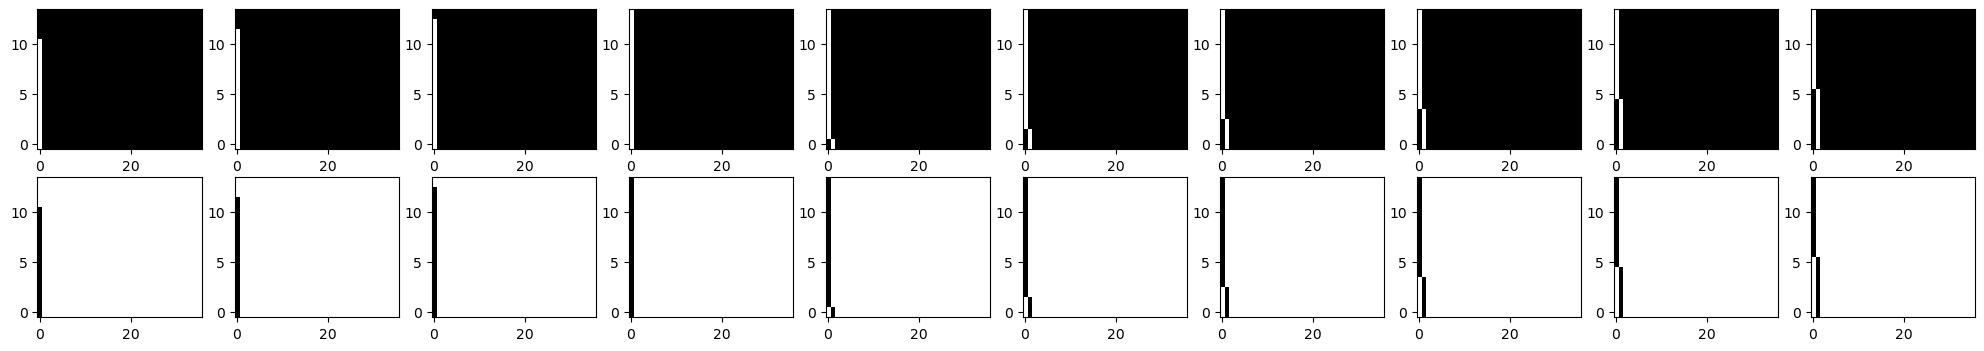

In [131]:
fig = plt.figure(figsize=(25, 4))
grid = matplotlib.gridspec.GridSpec(2, 10)
for col, i in enumerate(range(10, 20)):
    ax = plt.subplot(grid[0, col])
    ax.imshow(stimuli_pos[i,:].reshape(36,14).T, aspect='auto', interpolation='none', cmap='gray', origin='lower')
    ax = plt.subplot(grid[1, col])
    ax.imshow(stimuli_neg[i,:].reshape(36,14).T, aspect='auto', interpolation='none', cmap='gray', origin='lower')

In [134]:
results_pos = predict.predict(e.trials[0].model, inps=stimuli_pos, robs=dataset.robs[:stimuli_pos.shape[0]], calc_jacobian=True)
results_neg = predict.predict(e.trials[0].model, inps=stimuli_neg, robs=dataset.robs[:stimuli_neg.shape[0]], calc_jacobian=True)

100%|██████████████████████████████████████████████████████████████████████| 504/504 [00:06<00:00, 73.11it/s]


In [139]:
results_pos.jacobians[0][0].shape

(504, 4, 36, 4, 504)

# ON/OFF Map

In [140]:
# measure spatial and temporal extents of subunits
lgn_pos = []
proj_pos = []
iter0_pos = []
iter1_pos = []
iter2_pos = []
iter3_pos = []
iter4_pos = []
lgn_neg = []
proj_neg = []
iter0_neg = []
iter1_neg = []
iter2_neg = []
iter3_neg = []
iter4_neg = []
for idx,i in enumerate(range(68)):
    if i < 4: # it is not-iterative
        lgn_pos.append(results_pos.jacobians[0][0][:,i,17,0])
        lgn_neg.append(results_neg.jacobians[0][0][:,i,17,0])
    elif i < 20:
        proj_pos.append(results_pos.jacobians[0][1][:,i-4,17,0])
        proj_neg.append(results_neg.jacobians[0][1][:,i-4,17,0])
    elif i < 36:
        iter0_pos.append(results_pos.jacobians[0][2][:,0,i-20,17,0])
        iter0_neg.append(results_neg.jacobians[0][2][:,0,i-20,17,0])
    elif i < 52:
        iter1_pos.append(results_pos.jacobians[0][2][:,1,i-36,17,0])
        iter1_neg.append(results_neg.jacobians[0][2][:,1,i-36,17,0])
    elif i < 68:
        iter2_pos.append(results_pos.jacobians[0][2][:,2,i-52,17,0])
        iter2_neg.append(results_neg.jacobians[0][2][:,2,i-52,17,0])
    # elif i < 84:
    #     iter3_pos.append(results_pos.jacobians[0][0][:,3,i-68,17,0])
    #     iter3_neg.append(results_neg.jacobians[0][0][:,3,i-68,17,0])
    # elif i < 100:
    #     iter4_pos.append(results_pos.jacobians[0][0][:,4,i-84,17,0])
    #     iter4_neg.append(results_neg.jacobians[0][0][:,4,i-84,17,0])

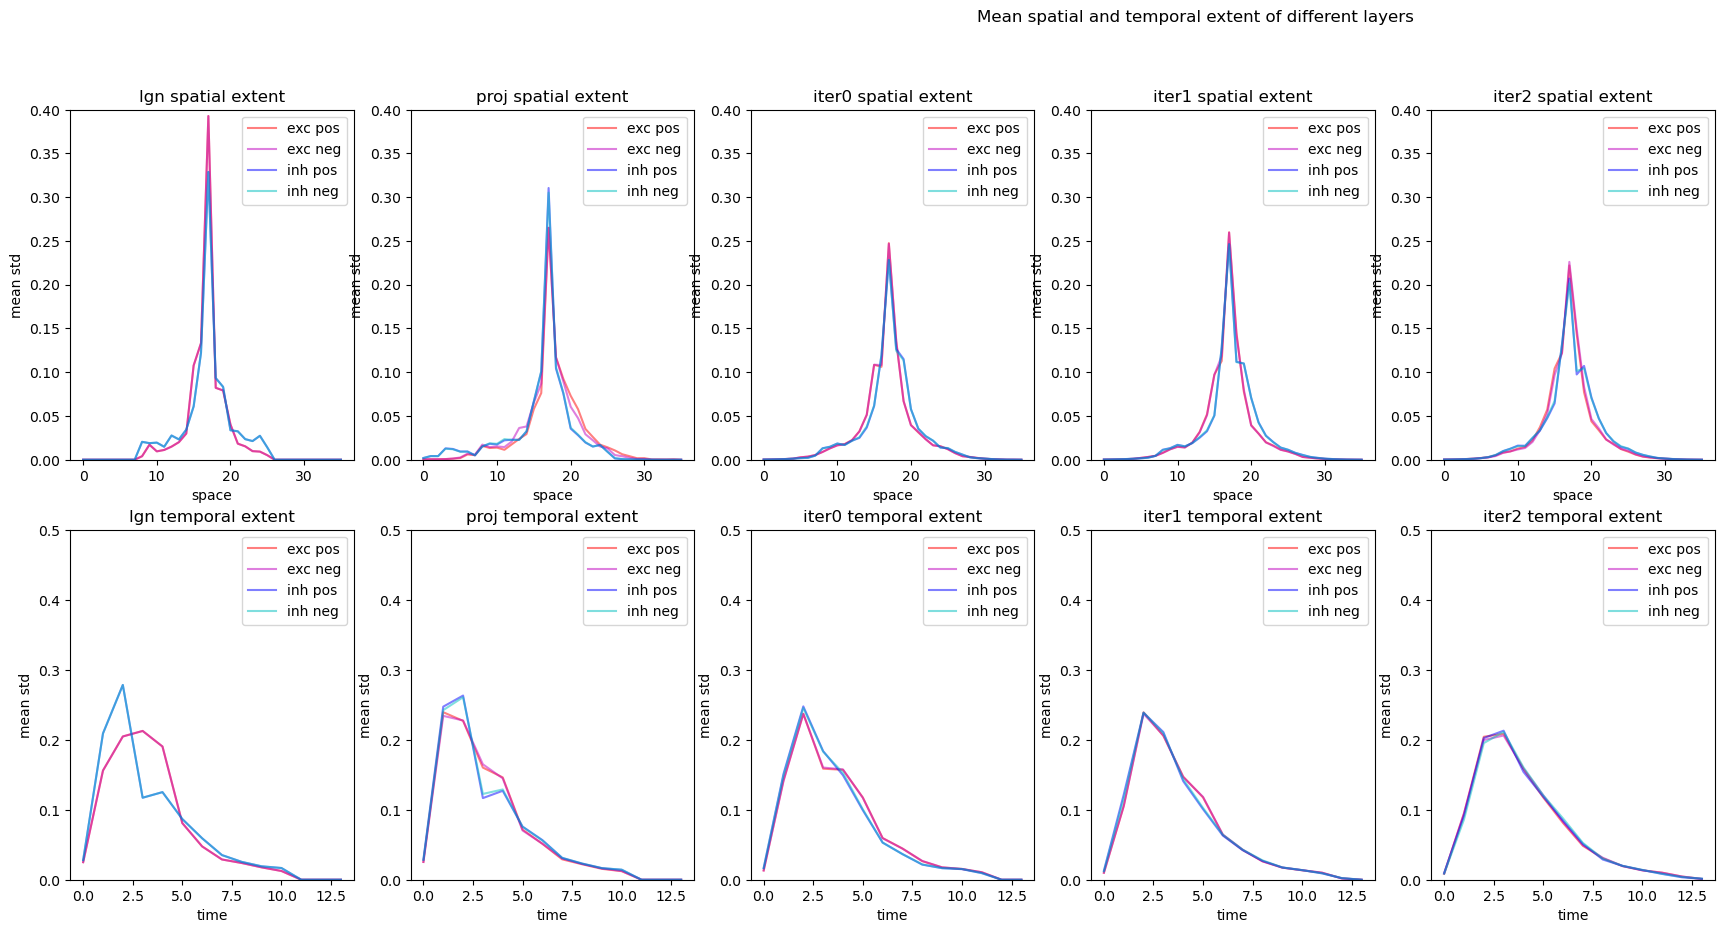

In [156]:
fig = plt.figure(figsize=(30,10))
grid = matplotlib.gridspec.GridSpec(2,7)
layer_idx = 0
for ims_pos,ims_neg,name in zip([lgn_pos, proj_pos, iter0_pos, iter1_pos, iter2_pos], 
                                [lgn_neg, proj_neg, iter0_neg, iter1_neg, iter2_neg], 
                                ['lgn', 'proj', 'iter0', 'iter1', 'iter2']):
    ksps = []
    ax = fig.add_subplot(grid[0,layer_idx])
    for i in range(len(ims_pos)//2):
        im = ims_pos[i].reshape(504,36,14)
        ksp = np.mean(np.std(im, axis=2), axis=0)
        ksp = ksp / np.sum(ksp)
        # find the max and shift the ksp so that the max is at 17
        max_idx = np.argmax(ksp)
        ksp = np.roll(ksp, 17-max_idx)
        if max_idx > 17:
            ksp[17-max_idx:] = 0 # set the rolled off part to 0
        else:
            ksp[:17-max_idx] = 0 # set the rolled off part to 0
        ksps.append(ksp)
    ax.plot(np.mean(ksps, axis=0), c='r', label='exc pos', alpha=0.5)
    ax.set_title(name + ' spatial extent')
    ax.set_xlabel('space')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.4])
    ax.legend()

    ksps = []
    for i in range(len(ims_neg)//2):
        im = ims_neg[i].reshape(504,36,14)
        ksp = np.mean(np.std(im, axis=2), axis=0)
        ksp = ksp / np.sum(ksp)
        # find the max and shift the ksp so that the max is at 17
        max_idx = np.argmax(ksp)
        ksp = np.roll(ksp, 17-max_idx)
        if max_idx > 17:
            ksp[17-max_idx:] = 0 # set the rolled off part to 0
        else:
            ksp[:17-max_idx] = 0 # set the rolled off part to 0
        ksps.append(ksp)
    ax.plot(np.mean(ksps, axis=0), c='m', label='exc neg', alpha=0.5)
    ax.set_title(name + ' spatial extent')
    ax.set_xlabel('space')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.4])
    ax.legend()

    ksps = []
    for i in range(len(ims_pos)//2, len(ims_pos)):
        im = ims_pos[i].reshape(504,36,14)
        ksp = np.mean(np.std(im, axis=2), axis=0)
        ksp = ksp / np.sum(ksp)
        # find the max and shift the ksp so that the max is at 17
        max_idx = np.argmax(ksp)
        ksp = np.roll(ksp, 17-max_idx)
        if max_idx > 17:
            ksp[17-max_idx:] = 0 # set the rolled off part to 0
        else:
            ksp[:17-max_idx] = 0 # set the rolled off part to 0
        ksps.append(ksp)
    ax.plot(np.mean(ksps, axis=0), c='b', label='inh pos', alpha=0.5)
    ax.set_title(name + ' spatial extent')
    ax.set_xlabel('space')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.4])
    ax.legend()

    ksps = []
    for i in range(len(ims_neg)//2, len(ims_neg)):
        im = ims_neg[i].reshape(504,36,14)
        ksp = np.mean(np.std(im, axis=2), axis=0)
        ksp = ksp / np.sum(ksp)
        # find the max and shift the ksp so that the max is at 17
        max_idx = np.argmax(ksp)
        ksp = np.roll(ksp, 17-max_idx)
        if max_idx > 17:
            ksp[17-max_idx:] = 0 # set the rolled off part to 0
        else:
            ksp[:17-max_idx] = 0 # set the rolled off part to 0
        ksps.append(ksp)
    ax.plot(np.mean(ksps, axis=0), c='c', label='inh neg', alpha=0.5)
    ax.set_title(name + ' spatial extent')
    ax.set_xlabel('space')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.4])
    ax.legend()

    kts = []
    ax = fig.add_subplot(grid[1,layer_idx])
    for i in range(len(ims_pos)//2):
        im = ims_pos[i].reshape(504,36,14)
        kt = np.mean(np.std(im, axis=1), axis=0)
        kt = kt / np.sum(kt)
        kts.append(kt)
    ax.plot(np.mean(kts, axis=0), c='r', label='exc pos', alpha=0.5)
    ax.set_title(name + ' temporal extent')
    ax.set_xlabel('time')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.5])
    ax.legend()

    kts = []
    for i in range(len(ims_neg)//2):
        im = ims_neg[i].reshape(504,36,14)
        kt = np.mean(np.std(im, axis=1), axis=0)
        kt = kt / np.sum(kt)
        kts.append(kt)
    ax.plot(np.mean(kts, axis=0), c='m', label='exc neg', alpha=0.5)
    ax.set_title(name + ' temporal extent')
    ax.set_xlabel('time')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.5])
    ax.legend()

    kts = []
    for i in range(len(ims_pos)//2, len(ims_pos)):
        im = ims_pos[i].reshape(504,36,14)
        kt = np.mean(np.std(im, axis=1), axis=0)
        kt = kt / np.sum(kt)
        kts.append(kt)
    ax.plot(np.mean(kts, axis=0), c='b', label='inh pos', alpha=0.5)
    ax.set_title(name + ' temporal extent')
    ax.set_xlabel('time')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.5])
    ax.legend()

    kts = []
    for i in range(len(ims_neg)//2, len(ims_neg)):
        im = ims_neg[i].reshape(504,36,14)
        kt = np.mean(np.std(im, axis=1), axis=0)
        kt = kt / np.sum(kt)
        kts.append(kt)
    ax.plot(np.mean(kts, axis=0), c='c', label='inh neg', alpha=0.5)
    ax.set_title(name + ' temporal extent')
    ax.set_xlabel('time')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.5])
    ax.legend()
    
    layer_idx += 1
_ = plt.suptitle('Mean spatial and temporal extent of different layers')

# pixel-wise activation map

In [192]:
# create sample stimuli (not lagged)
stimuli_pos = torch.zeros((14*36, 504)).float()
stimuli_neg = torch.zeros((14*36, 504)).float()
# put a +1 pixel at every spatial position every 20 frames
for i in range(stimuli_pos.shape[0]):
    stimuli_pos[i, i] = 10
    stimuli_neg[i, i] = -10

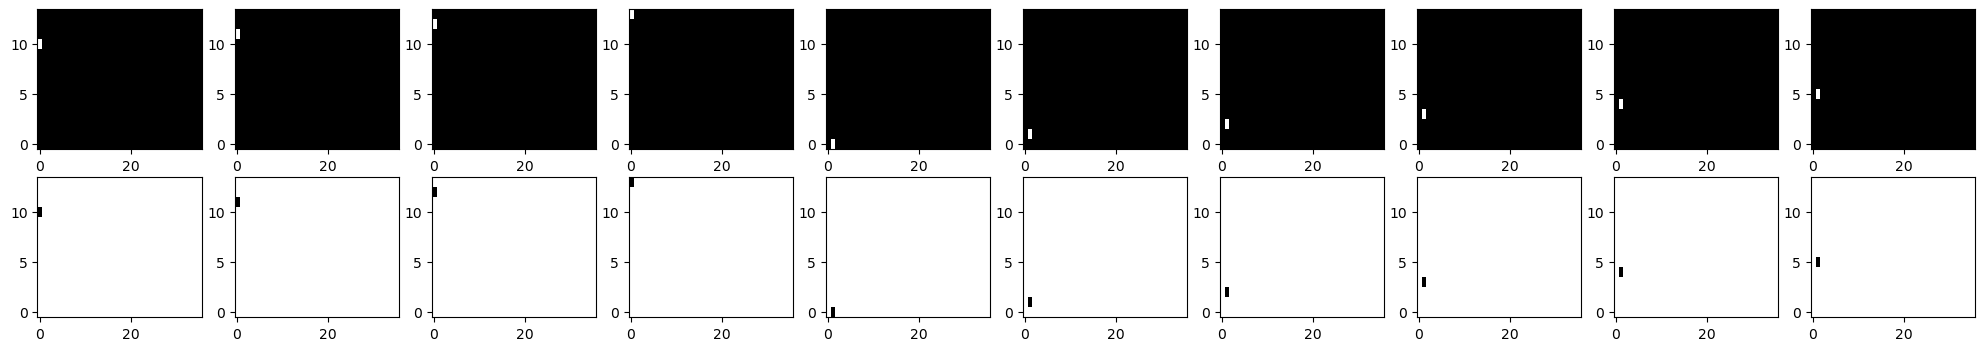

In [193]:
fig = plt.figure(figsize=(25, 4))
grid = matplotlib.gridspec.GridSpec(2, 10)
for col, i in enumerate(range(10, 20)):
    ax = plt.subplot(grid[0, col])
    ax.imshow(stimuli_pos[i,:].reshape(36,14).T, aspect='auto', interpolation='none', cmap='gray', origin='lower')
    ax = plt.subplot(grid[1, col])
    ax.imshow(stimuli_neg[i,:].reshape(36,14).T, aspect='auto', interpolation='none', cmap='gray', origin='lower')

In [194]:
results_pos = predict.predict(e.trials[0].model, inps=stimuli_pos, robs=dataset.robs[:stimuli_pos.shape[0]], calc_jacobian=False)
results_neg = predict.predict(e.trials[0].model, inps=stimuli_neg, robs=dataset.robs[:stimuli_neg.shape[0]], calc_jacobian=False)

# plot activation map

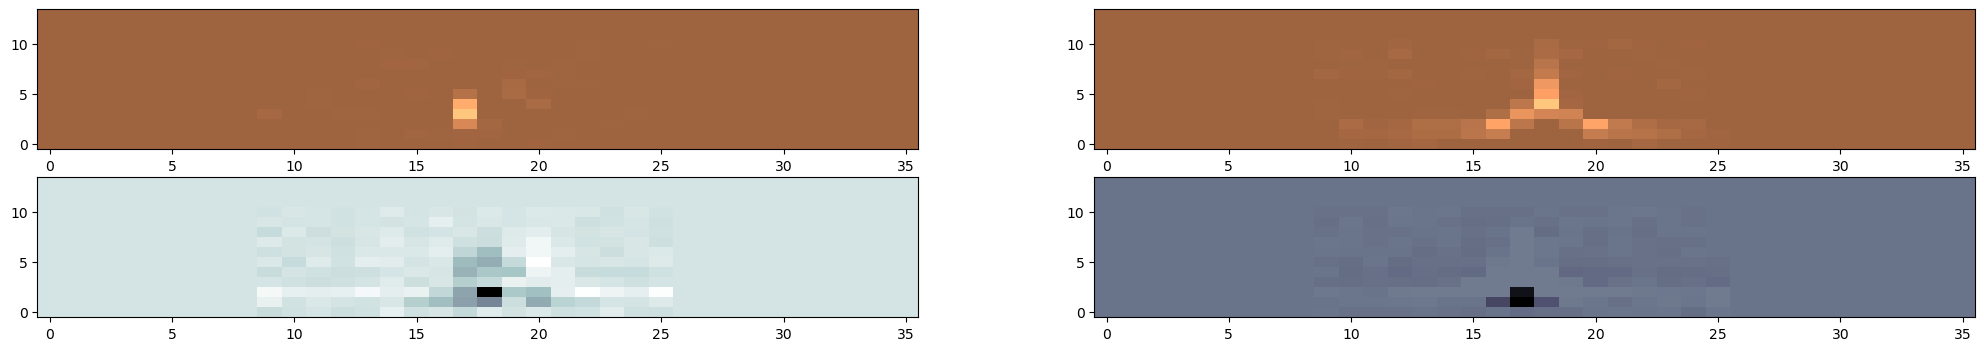

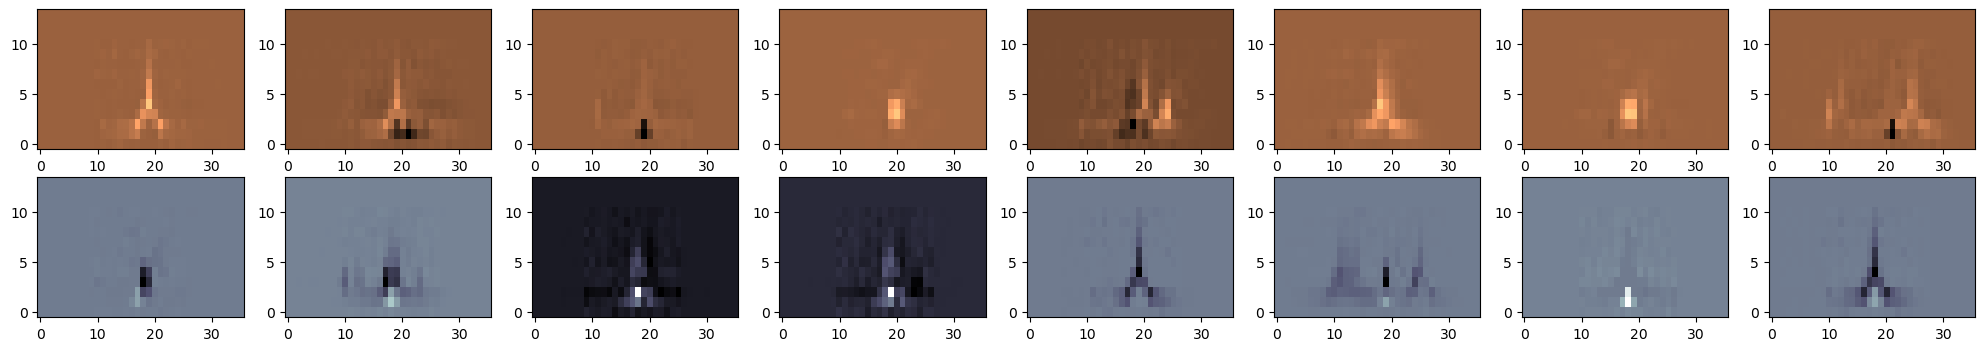

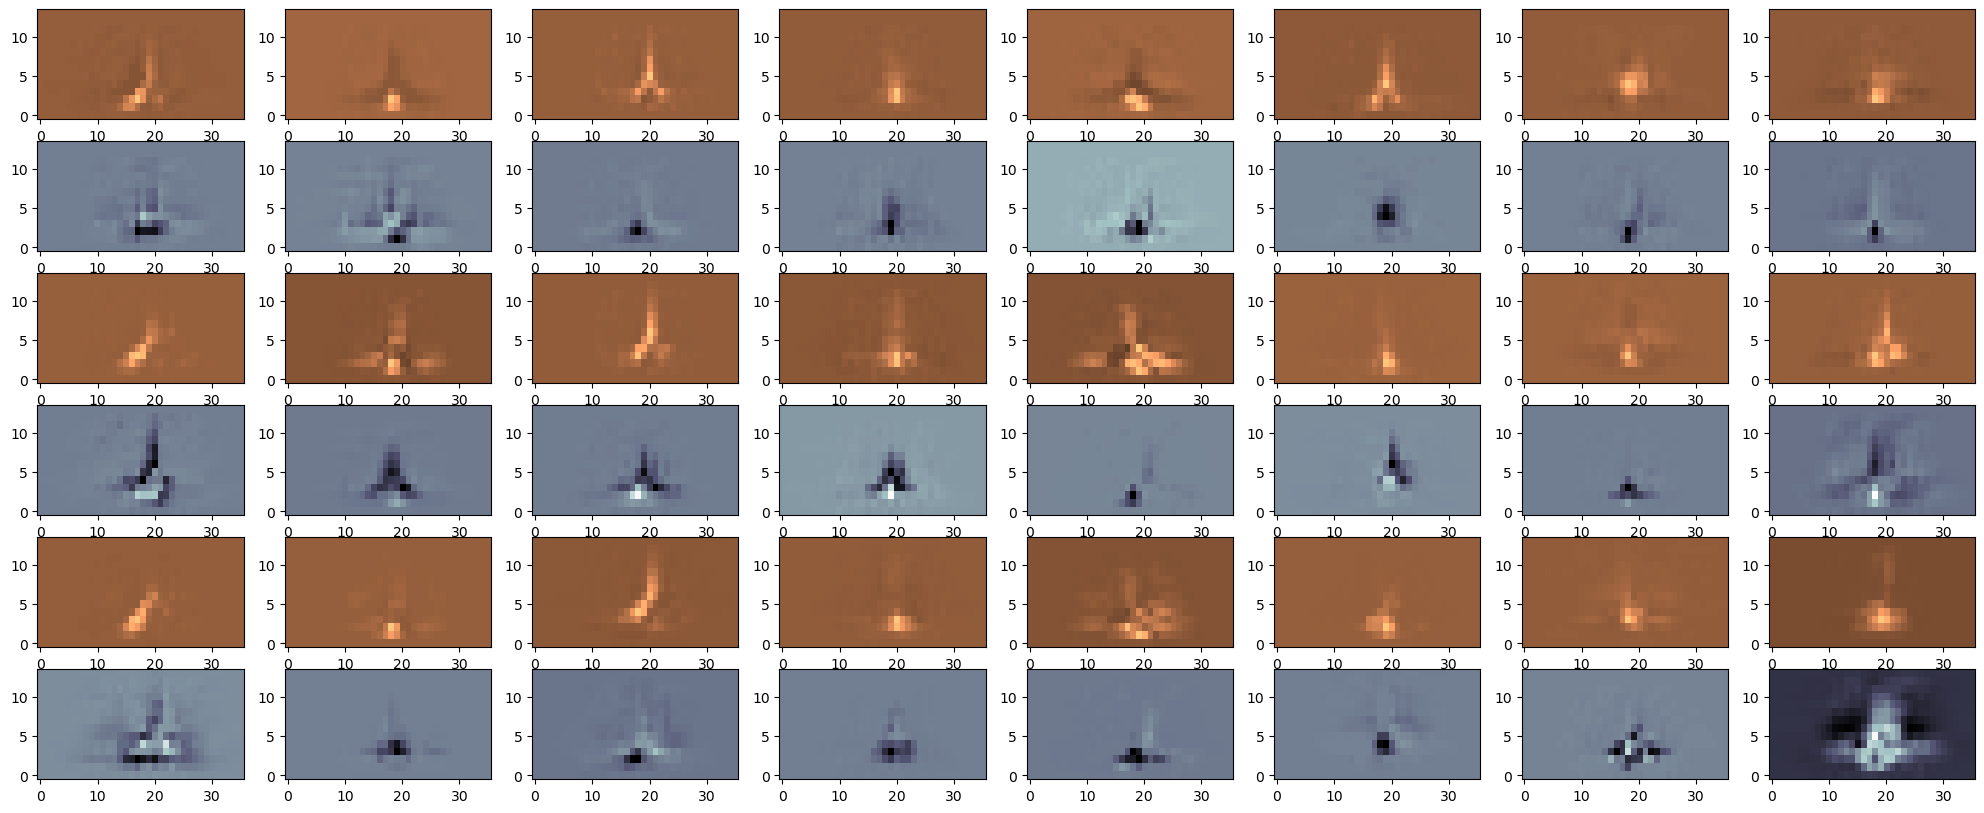

In [197]:
def plot_activation_map(results):
    for li in range(3):
        if li < 2:
            imax = np.max(np.abs(results.outputs[0][li][:,:, 17, 0, 0]))
            num_subunits = results.outputs[0][li].shape[1]
            fig = plt.figure(figsize=(25,4))
            for i in range(num_subunits):
                ax = fig.add_subplot(2,num_subunits//2,i+1)
                if i < num_subunits // 2:
                    cmap = 'copper'
                else:
                    cmap = 'bone'    
                plot.imagesc(results.outputs[0][li][:,i, 17, 0, 0].reshape(36,14), ax=ax, cmap=cmap)
        else:
            num_iter = results.outputs[0][li].shape[1]
            fig = plt.figure(figsize=(25,10))
            imax = np.max(np.abs(results.outputs[0][li][:,:,:, 17, 0, 0]))
            for iter in range(num_iter):
                num_subunits = results.outputs[0][li].shape[2]
                for i in range(num_subunits):
                    ax = fig.add_subplot(num_iter*2,num_subunits//2,num_subunits*iter+i+1)
                    if i < num_subunits // 2:
                        cmap = 'copper'
                    else:
                        cmap = 'bone'
                    plot.imagesc(results.outputs[0][li][:,iter,i, 17, 0, 0].reshape(36,14), ax=ax, cmap=cmap)

plot_activation_map(results_pos)

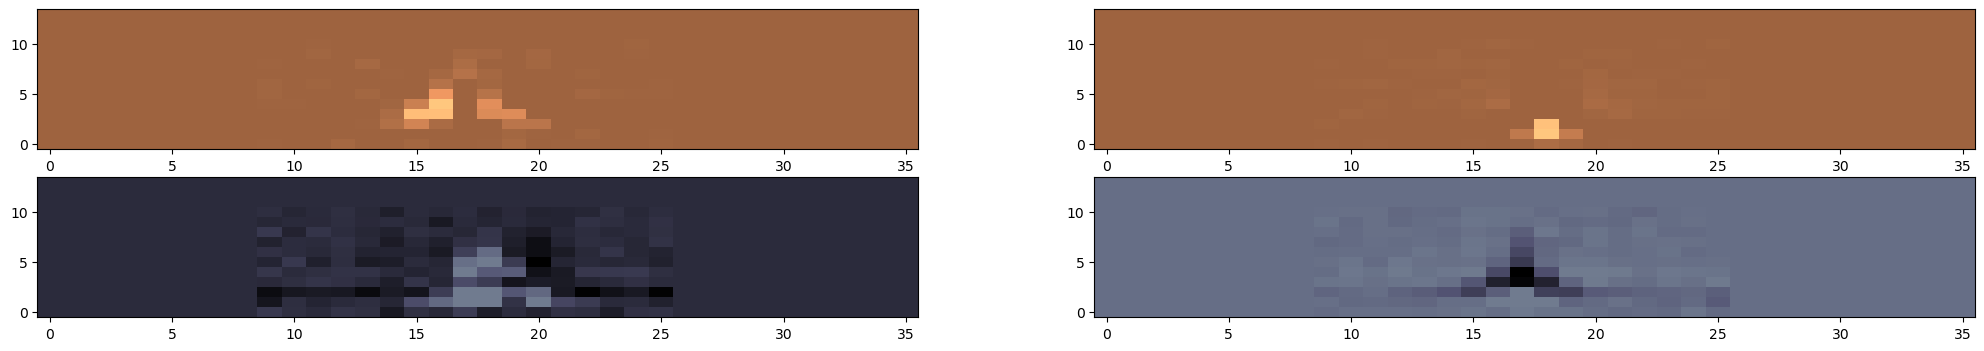

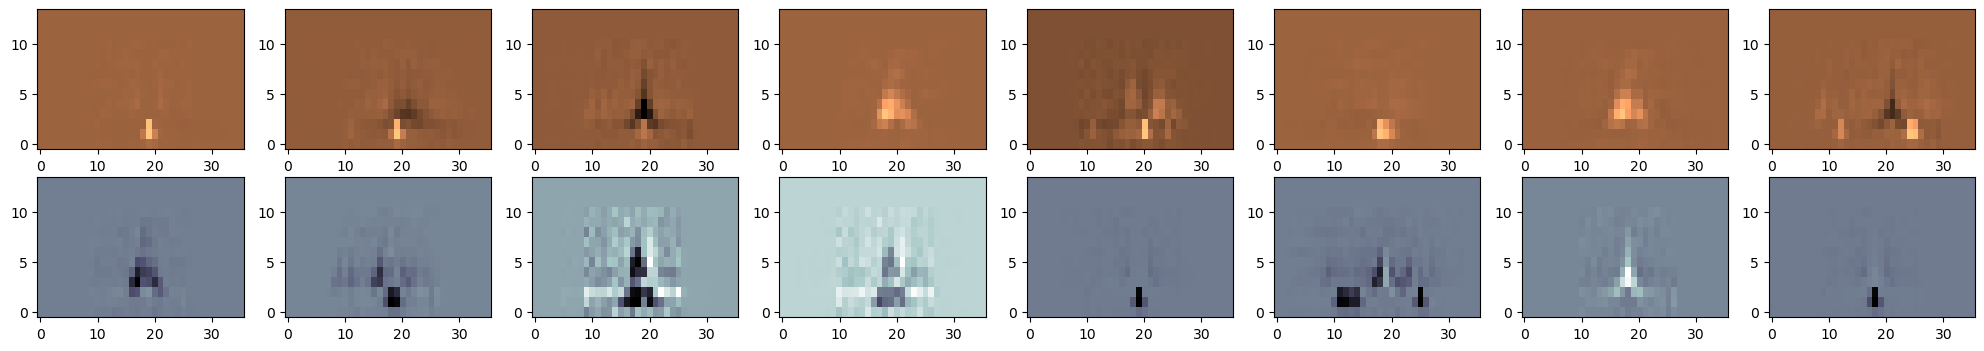

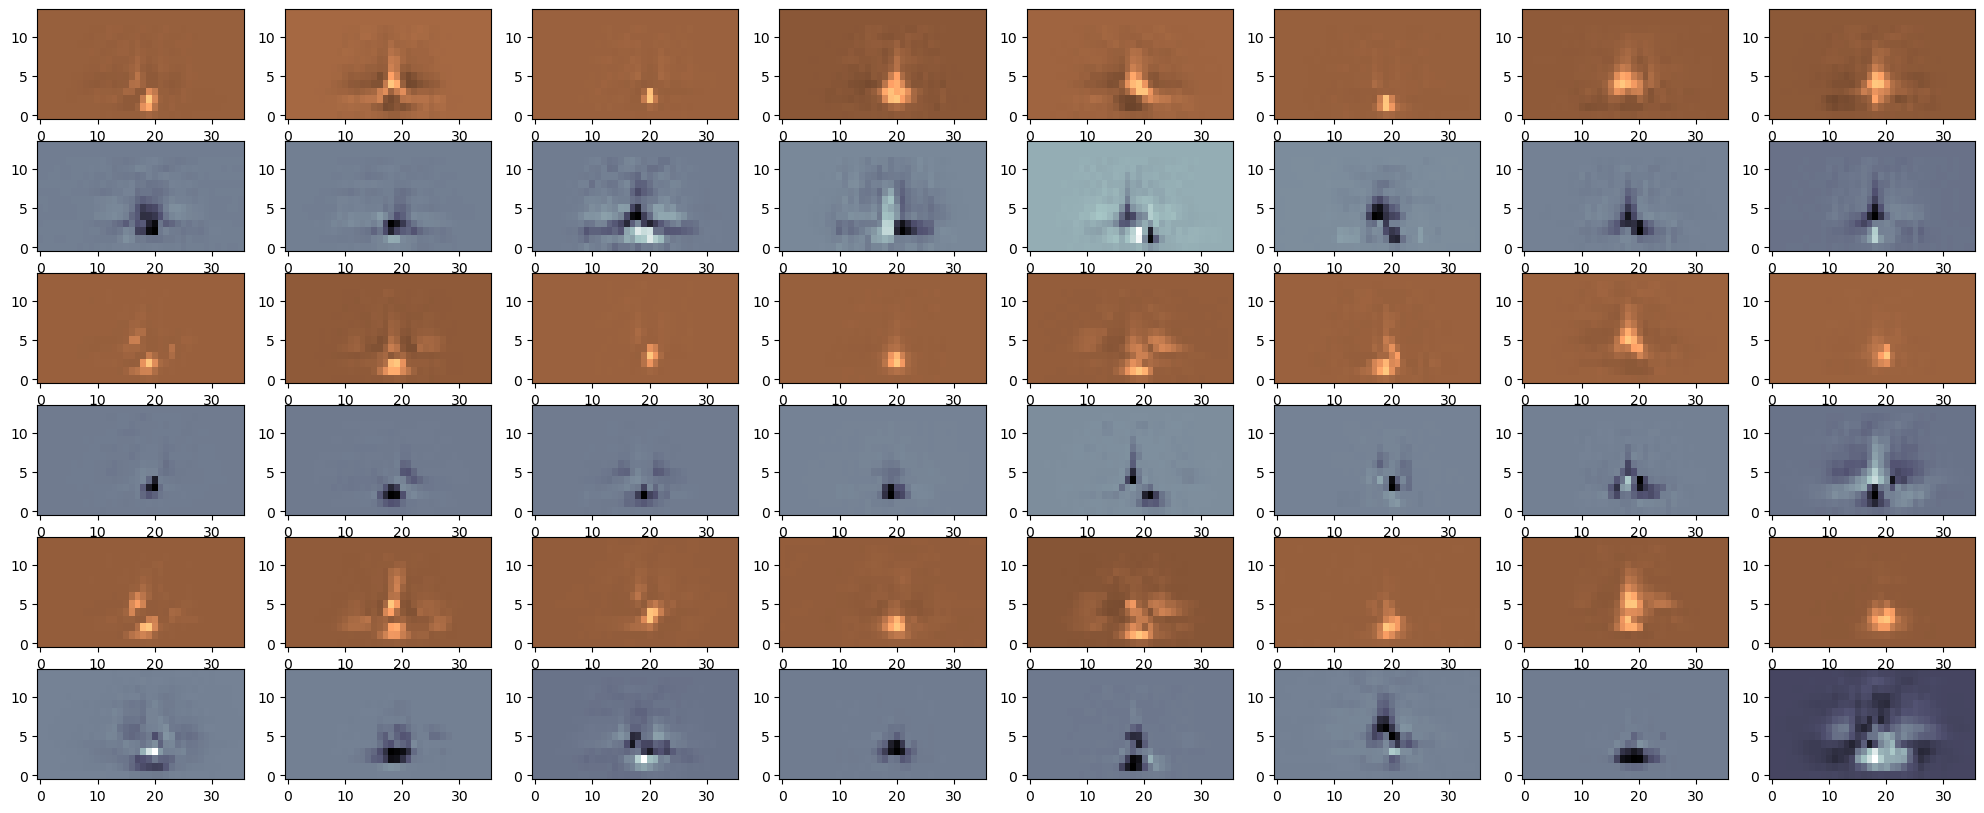

In [198]:
plot_activation_map(results_neg)

# summarize activation map

In [199]:
# measure spatial and temporal extents of subunits
lgn_pos = []
proj_pos = []
iter0_pos = []
iter1_pos = []
iter2_pos = []
iter3_pos = []
iter4_pos = []
lgn_neg = []
proj_neg = []
iter0_neg = []
iter1_neg = []
iter2_neg = []
iter3_neg = []
iter4_neg = []
for idx,i in enumerate(range(68)):
    if i < 4: # it is not-iterative
        lgn_pos.append(results_pos.outputs[0][0][:,i,17,0])
        lgn_neg.append(results_neg.outputs[0][0][:,i,17,0])
    elif i < 20:
        proj_pos.append(results_pos.outputs[0][1][:,i-4,17,0])
        proj_neg.append(results_neg.outputs[0][1][:,i-4,17,0])
    elif i < 36:
        iter0_pos.append(results_pos.outputs[0][2][:,0,i-20,17,0])
        iter0_neg.append(results_neg.outputs[0][2][:,0,i-20,17,0])
    elif i < 52:
        iter1_pos.append(results_pos.outputs[0][2][:,1,i-36,17,0])
        iter1_neg.append(results_neg.outputs[0][2][:,1,i-36,17,0])
    elif i < 68:
        iter2_pos.append(results_pos.outputs[0][2][:,2,i-52,17,0])
        iter2_neg.append(results_neg.outputs[0][2][:,2,i-52,17,0])
    # elif i < 84:
    #     iter3_pos.append(results_pos.outputs[0][0][:,3,i-68,17,0])
    #     iter3_neg.append(results_neg.outputs[0][0][:,3,i-68,17,0])
    # elif i < 100:
    #     iter4_pos.append(results_pos.outputs[0][0][:,4,i-84,17,0])
    #     iter4_neg.append(results_neg.outputs[0][0][:,4,i-84,17,0])

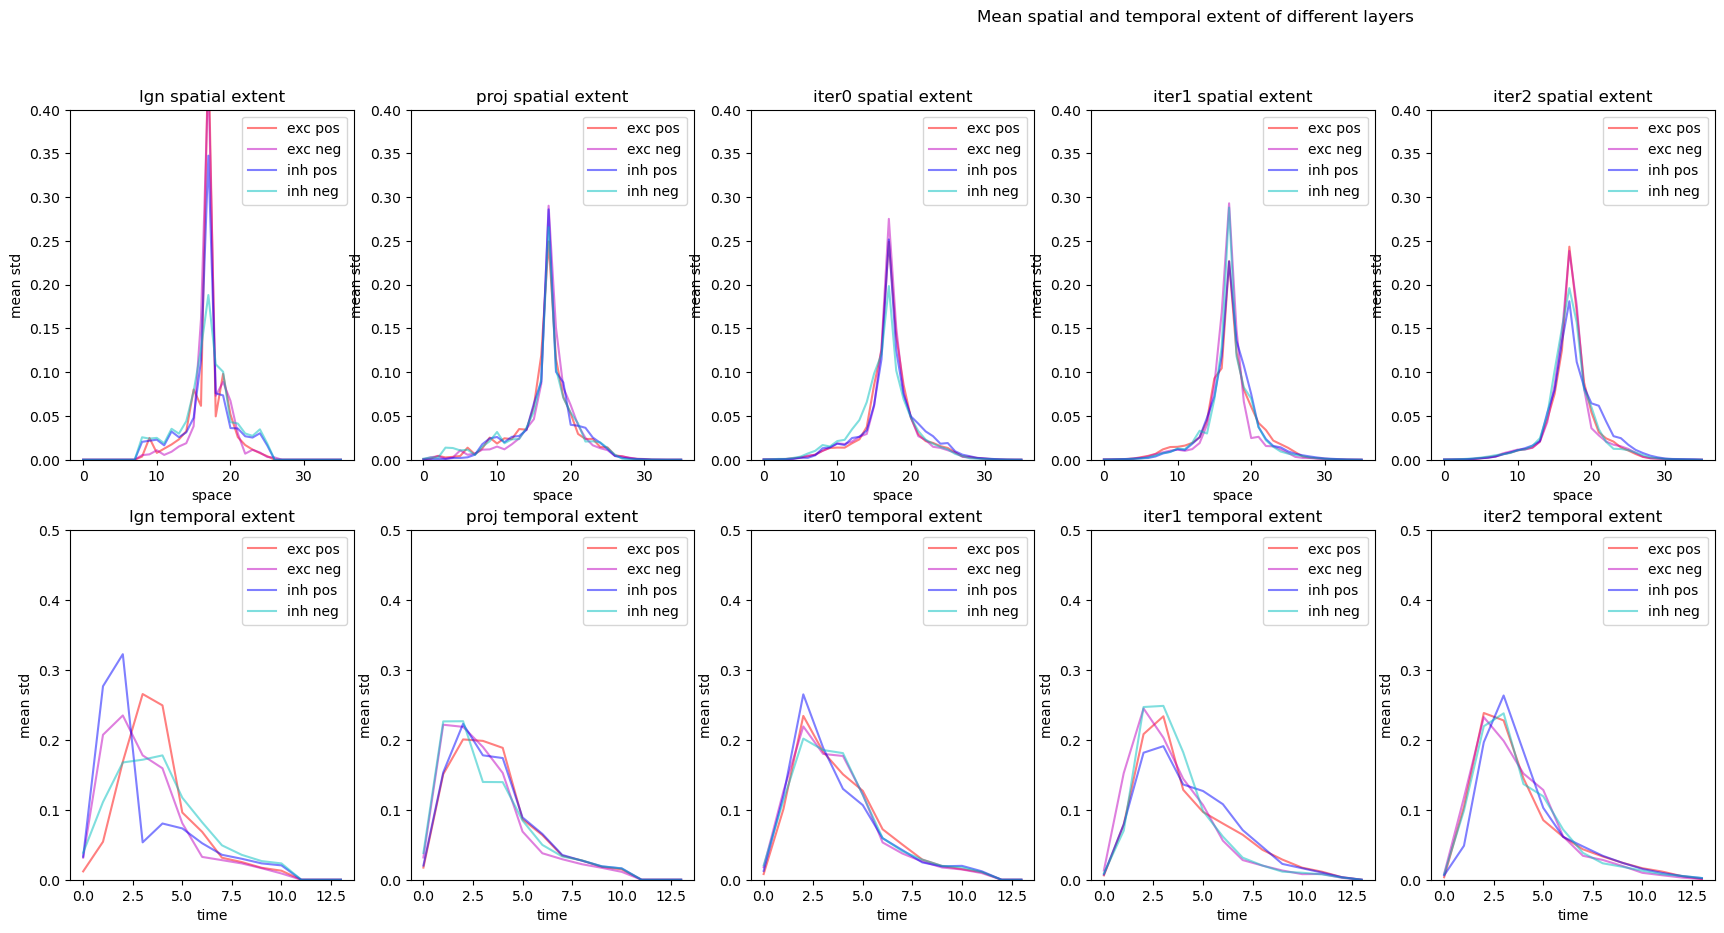

In [201]:
fig = plt.figure(figsize=(30,10))
grid = matplotlib.gridspec.GridSpec(2,7)
layer_idx = 0
for ims_pos,ims_neg,name in zip([lgn_pos, proj_pos, iter0_pos, iter1_pos, iter2_pos],
                                [lgn_neg, proj_neg, iter0_neg, iter1_neg, iter2_neg],
                                ['lgn', 'proj', 'iter0', 'iter1', 'iter2']):
    ksps = []
    ax = fig.add_subplot(grid[0,layer_idx])
    for i in range(len(ims_pos)//2):
        im = ims_pos[i].reshape(36,14)
        ksp = np.std(im, axis=1)
        ksp = ksp / np.sum(ksp)
        # find the max and shift the ksp so that the max is at 17
        max_idx = np.argmax(ksp)
        ksp = np.roll(ksp, 17-max_idx)
        if max_idx > 17:
            ksp[17-max_idx:] = 0 # set the rolled off part to 0
        else:
            ksp[:17-max_idx] = 0 # set the rolled off part to 0
        ksps.append(ksp)
    ax.plot(np.mean(ksps, axis=0), c='r', label='exc pos', alpha=0.5)
    ax.set_title(name + ' spatial extent')
    ax.set_xlabel('space')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.4])
    ax.legend()

    ksps = []
    for i in range(len(ims_neg)//2):
        im = ims_neg[i].reshape(36,14)
        ksp = np.std(im, axis=1)
        ksp = ksp / np.sum(ksp)
        # find the max and shift the ksp so that the max is at 17
        max_idx = np.argmax(ksp)
        ksp = np.roll(ksp, 17-max_idx)
        if max_idx > 17:
            ksp[17-max_idx:] = 0 # set the rolled off part to 0
        else:
            ksp[:17-max_idx] = 0 # set the rolled off part to 0
        ksps.append(ksp)
    ax.plot(np.mean(ksps, axis=0), c='m', label='exc neg', alpha=0.5)
    ax.set_title(name + ' spatial extent')
    ax.set_xlabel('space')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.4])
    ax.legend()

    ksps = []
    for i in range(len(ims_pos)//2, len(ims_pos)):
        im = ims_pos[i].reshape(36,14)
        ksp = np.std(im, axis=1)
        ksp = ksp / np.sum(ksp)
        # find the max and shift the ksp so that the max is at 17
        max_idx = np.argmax(ksp)
        ksp = np.roll(ksp, 17-max_idx)
        if max_idx > 17:
            ksp[17-max_idx:] = 0 # set the rolled off part to 0
        else:
            ksp[:17-max_idx] = 0 # set the rolled off part to 0
        ksps.append(ksp)
    ax.plot(np.mean(ksps, axis=0), c='b', label='inh pos', alpha=0.5)
    ax.set_title(name + ' spatial extent')
    ax.set_xlabel('space')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.4])
    ax.legend()

    ksps = []
    for i in range(len(ims_neg)//2, len(ims_neg)):
        im = ims_neg[i].reshape(36,14)
        ksp = np.std(im, axis=1)
        ksp = ksp / np.sum(ksp)
        # find the max and shift the ksp so that the max is at 17
        max_idx = np.argmax(ksp)
        ksp = np.roll(ksp, 17-max_idx)
        if max_idx > 17:
            ksp[17-max_idx:] = 0 # set the rolled off part to 0
        else:
            ksp[:17-max_idx] = 0 # set the rolled off part to 0
        ksps.append(ksp)
    ax.plot(np.mean(ksps, axis=0), c='c', label='inh neg', alpha=0.5)
    ax.set_title(name + ' spatial extent')
    ax.set_xlabel('space')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.4])
    ax.legend()

    kts = []
    ax = fig.add_subplot(grid[1,layer_idx])
    for i in range(len(ims_pos)//2):
        im = ims_pos[i].reshape(36,14)
        kt = np.std(im, axis=0)
        kt = kt / np.sum(kt)
        kts.append(kt)
    ax.plot(np.mean(kts, axis=0), c='r', label='exc pos', alpha=0.5)
    ax.set_title(name + ' temporal extent')
    ax.set_xlabel('time')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.5])
    ax.legend()

    kts = []
    for i in range(len(ims_neg)//2):
        im = ims_neg[i].reshape(36,14)
        kt = np.std(im, axis=0)
        kt = kt / np.sum(kt)
        kts.append(kt)
    ax.plot(np.mean(kts, axis=0), c='m', label='exc neg', alpha=0.5)
    ax.set_title(name + ' temporal extent')
    ax.set_xlabel('time')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.5])
    ax.legend()

    kts = []
    for i in range(len(ims_pos)//2, len(ims_pos)):
        im = ims_pos[i].reshape(36,14)
        kt = np.std(im, axis=0)
        kt = kt / np.sum(kt)
        kts.append(kt)
    ax.plot(np.mean(kts, axis=0), c='b', label='inh pos', alpha=0.5)
    ax.set_title(name + ' temporal extent')
    ax.set_xlabel('time')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.5])
    ax.legend()

    kts = []
    for i in range(len(ims_neg)//2, len(ims_neg)):
        im = ims_neg[i].reshape(36,14)
        kt = np.std(im, axis=0)
        kt = kt / np.sum(kt)
        kts.append(kt)
    ax.plot(np.mean(kts, axis=0), c='c', label='inh neg', alpha=0.5)
    ax.set_title(name + ' temporal extent')
    ax.set_xlabel('time')
    ax.set_ylabel('mean std')
    ax.set_ylim([0,0.5])
    ax.legend()

    layer_idx += 1
_ = plt.suptitle('Mean spatial and temporal extent of different layers')

In [205]:
def plot_summary_stats(lgn, proj, iter0, iter1, iter2):
    fig = plt.figure(figsize=(30,10))
    grid = matplotlib.gridspec.GridSpec(2,7)
    layer_idx = 0
    for ims,name in zip([lgn, proj, iter0, iter1, iter2], ['lgn', 'proj', 'iter0', 'iter1', 'iter2']):
        ksps = []
        ax = fig.add_subplot(grid[0,layer_idx])
        for i in range(len(ims)//2):
            im = ims[i].reshape(36,14)
            ksp = np.std(im, axis=1)
            ksp = ksp / np.sum(ksp)
            # find the max and shift the ksp so that the max is at 17
            max_idx = np.argmax(ksp)
            ksp = np.roll(ksp, 17-max_idx)
            if max_idx > 17:
                ksp[17-max_idx:] = 0 # set the rolled off part to 0
            else:
                ksp[:17-max_idx] = 0 # set the rolled off part to 0
            ksps.append(ksp)
        ax.plot(np.mean(ksps, axis=0), c='r', label='exc', alpha=0.5)
        ax.set_title(name + ' spatial extent')
        ax.set_xlabel('space')
        ax.set_ylabel('mean std')
        ax.set_ylim([0,0.4])
        ax.legend()
    
        ksps = []
        for i in range(len(ims)//2, len(ims)):
            im = ims[i].reshape(36,14)
            ksp = np.std(im, axis=1)
            ksp = ksp / np.sum(ksp)
            # find the max and shift the ksp so that the max is at 17
            max_idx = np.argmax(ksp)
            ksp = np.roll(ksp, 17-max_idx)
            if max_idx > 17:
                ksp[17-max_idx:] = 0 # set the rolled off part to 0
            else:
                ksp[:17-max_idx] = 0 # set the rolled off part to 0
            ksps.append(ksp)
        ax.plot(np.mean(ksps, axis=0), c='b', label='inh', alpha=0.5)
        ax.set_title(name + ' spatial extent')
        ax.set_xlabel('space')
        ax.set_ylabel('mean std')
        ax.set_ylim([0,0.4])
        ax.legend()
    
        kts = []
        ax = fig.add_subplot(grid[1,layer_idx])
        for i in range(len(ims)//2):
            im = ims[i].reshape(36,14)
            kt = np.std(im, axis=0)
            kt = kt / np.sum(kt)
            kts.append(kt)
        ax.plot(np.mean(kts, axis=0), c='r', label='exc', alpha=0.5)
        ax.set_title(name + ' temporal extent')
        ax.set_xlabel('time')
        ax.set_ylabel('mean std')
        ax.set_ylim([0,0.5])
        ax.legend()
    
        kts = []
        for i in range(len(ims)//2, len(ims)):
            im = ims[i].reshape(36,14)
            kt = np.std(im, axis=0)
            kt = kt / np.sum(kt)
            kts.append(kt)
        ax.plot(np.mean(kts, axis=0), c='b', label='inh', alpha=0.5)
        ax.set_title(name + ' temporal extent')
        ax.set_xlabel('time')
        ax.set_ylabel('mean std')
        ax.set_ylim([0,0.5])
        ax.legend()
    
        layer_idx += 1
    _ = plt.suptitle('Mean spatial and temporal extent of different layers')

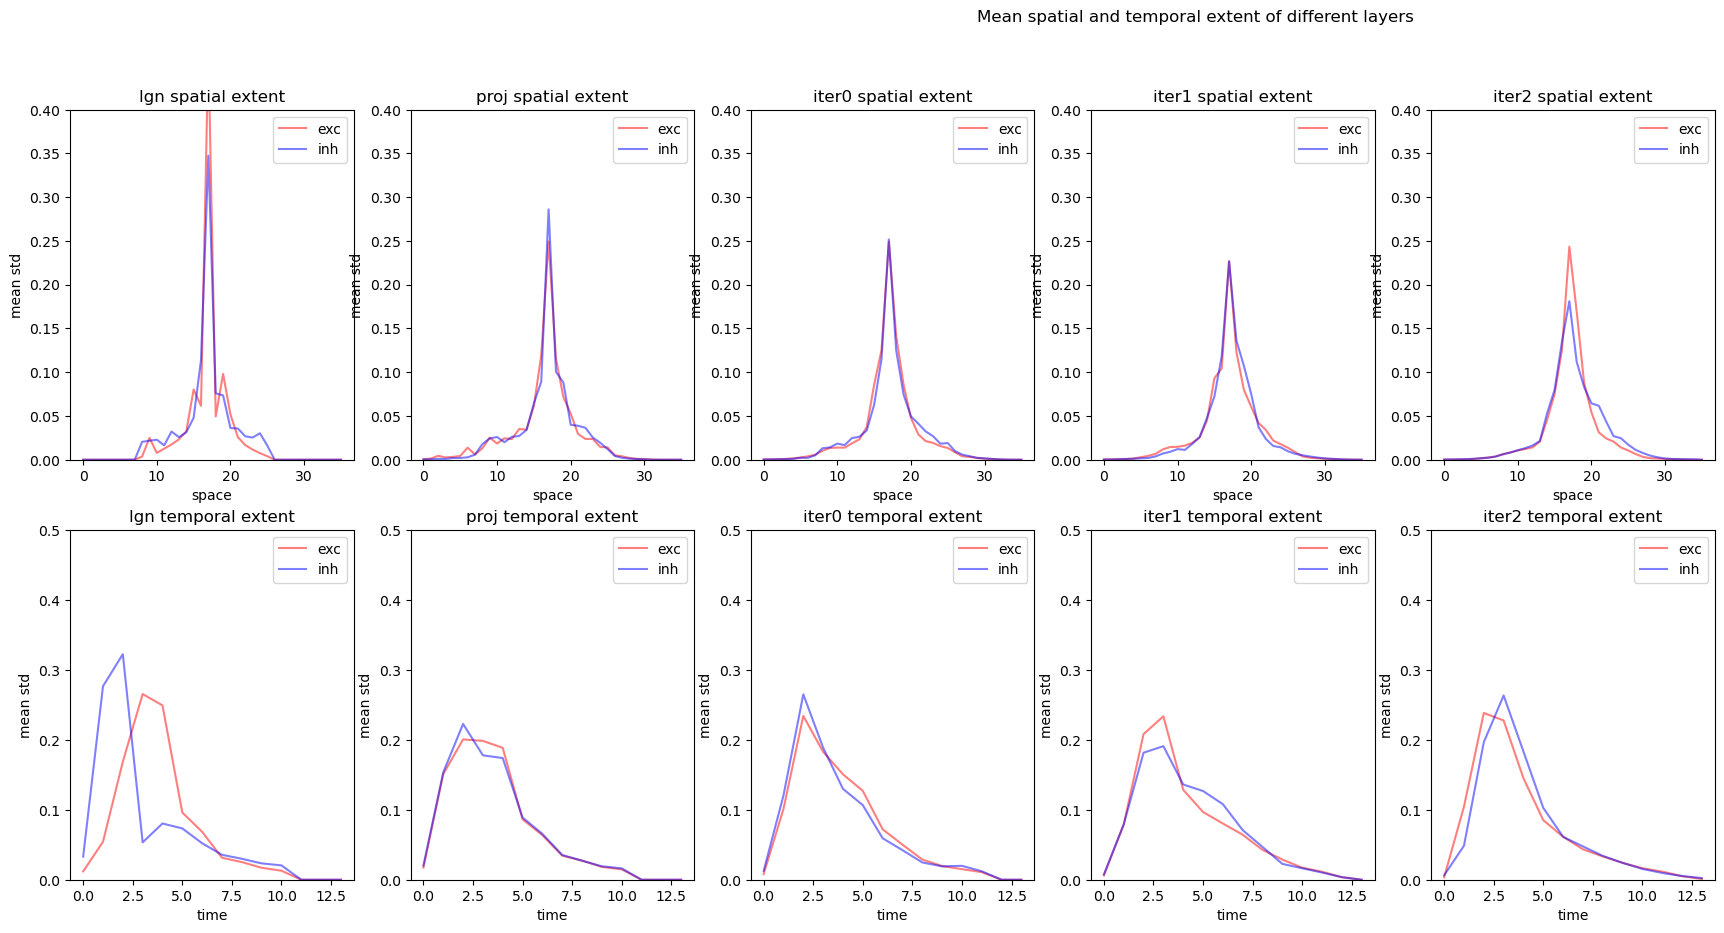

In [206]:
plot_summary_stats(lgn_pos, proj_pos, iter0_pos, iter1_pos, iter2_pos)

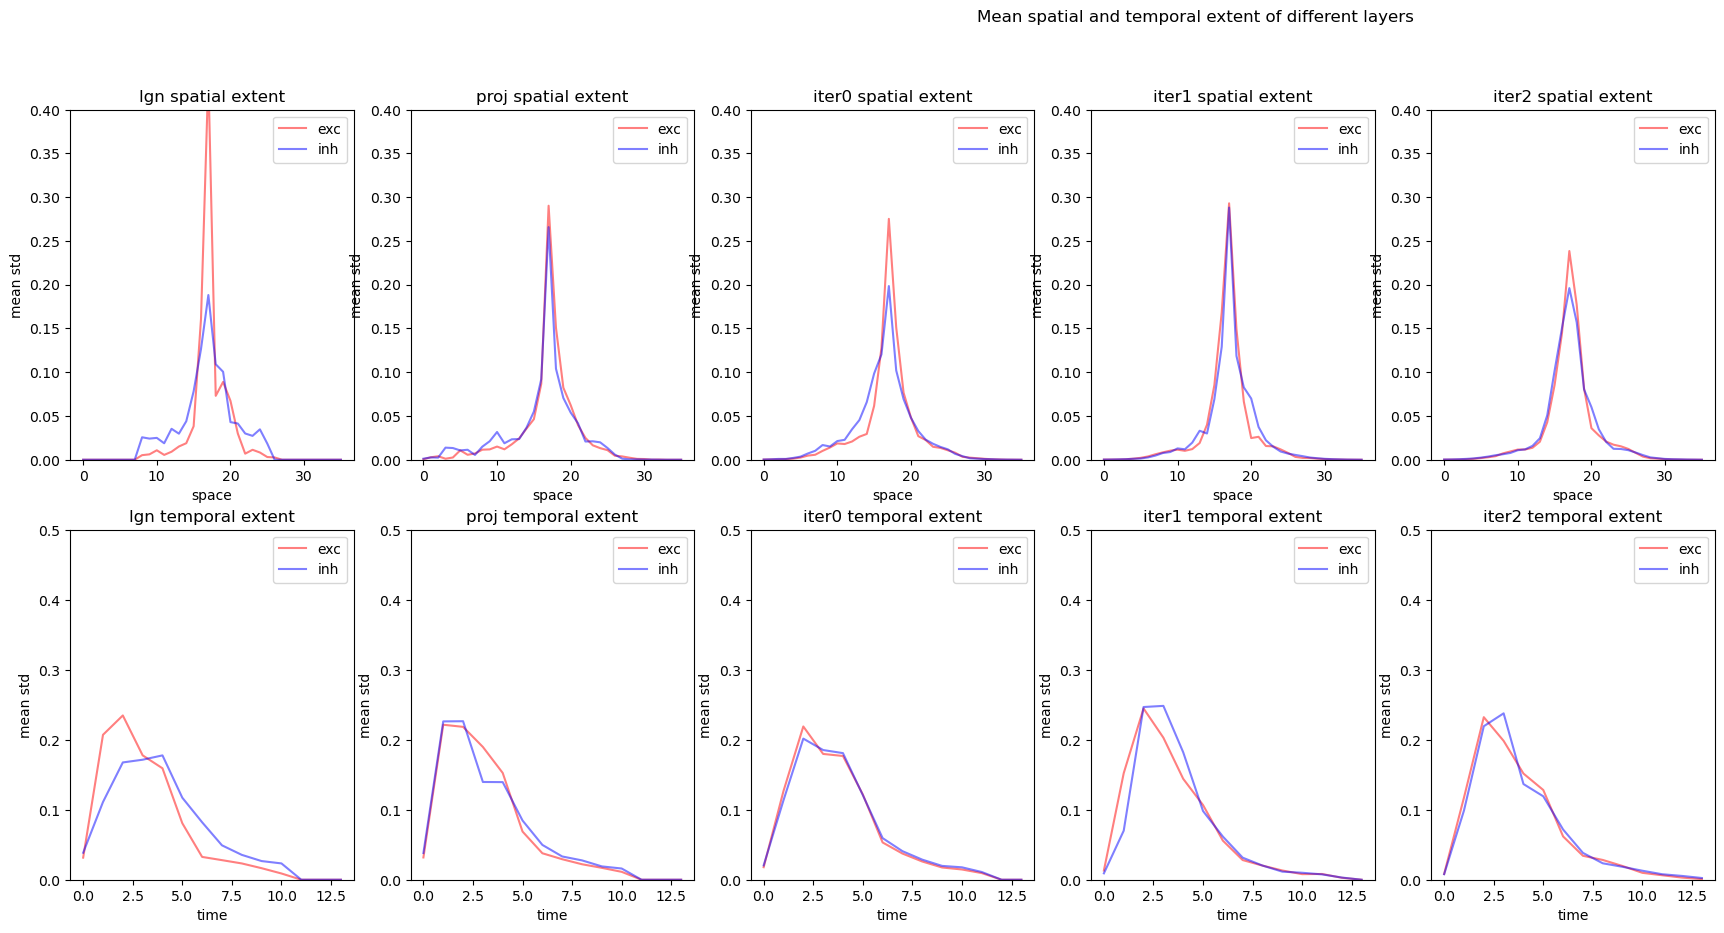

In [207]:
plot_summary_stats(lgn_neg, proj_neg, iter0_neg, iter1_neg, iter2_neg)